# Comparação entre distâncias de isolamento

In [1]:
from tabulate import tabulate
import matplotlib.pyplot as plt
import pandas as pd
from math import degrees, exp, sqrt
from IPython.display import HTML, display
from normaslt import types, nbr5422, nbr1985, iec, en
from normaslt.cigre import anguloBalancoTB348
from normaslt.draw import find_line_start, minDistancePts, plot_dimension, plot_balanco, plot_cadeia, plot_distance_radius, plot_line_pt, xmax


## Distâncias elétricas para circuitos
NBR 5422 - Metodologia proposta
$$
\begin{align}
d_{ft,ff} & = 1.642 \left[ \exp \left( \frac{\frac{U_s}{\sqrt{3}} \, F_{tmo}}{750 \, k_{aff} \, k_{zff} \, k_{gff}}\right) - 1\right]^{0.83} \\
d_{ff,ff} & = 1.642 \left[ \exp \left( \frac{U_s \, F_{tmo}}{750 \, k_{aff} \, k_{zff} \, k_{gff}}\right) - 1\right]^{0.83} \\
d_{ft,fl} & = 2.174 \left[ \exp \left( \frac{K_{cs} \, U_s \frac{\sqrt{2}}{\sqrt{3}} \, F_{sfl}}{1080 \, k_{afl} \, k_{zfl} \, k_{g}}\right) - 1\right] \\
d_{ff,fl} & = 2.174 \left[ \exp \left( \frac{1.4 \, K_{cs} \, U_s \frac{\sqrt{2}}{\sqrt{3}} \, F_{sfl}}{1080 \, k_{afl} \, k_{zfl} \, k_{g}}\right) - 1\right]
\end{align}
$$
Sendo para $d_{ff}$ os gaps do tipo "condutor-condutor"?

In [2]:
vnom = [69, 138, 230, 345, 440, 500, 765, 1000]
vmax = [72.5, 145., 242., 362., 460., 550., 800., 1100.]
fsfl = [3., 3., 3., 3., 2.4, 2.4, 2., 1.8]
vfr = [369., 510., 865., 1220., 1500., 1785., 2495., 3415.] # calculo pelo número de isoladores - planilha João Clavio
kgft = 1.45 # condutor-braço
ka = 0.95
kcs = 1.35
alpha = 0.5
kgff = 1.52 if alpha == 0.33 else 1.62 # condutor-condutor
dftff = []
dftfl = []
dftfr = []
dffff = []
dfffl = []
dfffr = []
idx = pd.MultiIndex.from_arrays([
    ['$U_{max}$', 'Fsfl', '\(U_{fr}\)', 'Fase-terra','Fase-terra','Fase-terra','Fase-fase','Fase-fase','Fase-fase'],
    ['', '', '', '$d_{ff}$','$d_{fl}$','$d_{fr}$','$d_{ff}$','$d_{fl}$','$d_{fr}$']
])
for vn, vm, vf, f in zip(vnom, vmax, vfr, fsfl):
  ftmo=vm/vn
  dftff.append(nbr5422.espacFTFreqFund(Us=vn, Ftmo=ftmo, kaff=ka, kg=kgft))
  dftfl.append(nbr5422.espacFTFrenteLenta(Us=vn, Kcs=kcs, Fsfl=f, kafl=ka, kg=kgft))
  dftfr.append(nbr5422.espacFTFrenteRapida(ufr=vf, kafr=ka, kg=kgft))
  dffff.append(nbr5422.espacFFFreqFund(Us=vn, Ftmo=ftmo, kaff=ka, kg=kgff))
  dfffl.append(nbr5422.espacFFFrenteLenta(Us=vn, Kcs=kcs, Fsfl=f, kafl=ka, kg=kgff, alpha=alpha))
  dfffr.append(nbr5422.espacFFFrenteRapida(ufr=vf, kafr=ka, kg=kgft))

df = pd.DataFrame(zip(vmax, fsfl, vfr, dftff, dftfl, dftfr, dffff, dfffl, dfffr),
                  pd.Index(vnom),
                  columns=idx
                  )
df.style.format(precision=3).to_latex()

#table = zip(vnom, dftff, dftfl, dftfr, dffff, dfffl)
#display(HTML('<h2>Método NBR 5422 proposto</h2>'))
#display(HTML(tabulate(table, headers=['Vn', 'dftff', 'dftfl', 'dftfr', 'dffff', 'dfffl'], tablefmt='html')))

<>:17: SyntaxWarning: invalid escape sequence '\('
<>:17: SyntaxWarning: invalid escape sequence '\('
/tmp/ipykernel_279562/1542131506.py:17: SyntaxWarning: invalid escape sequence '\('
  ['$U_{max}$', 'Fsfl', '\(U_{fr}\)', 'Fase-terra','Fase-terra','Fase-terra','Fase-fase','Fase-fase','Fase-fase'],
/tmp/ipykernel_279562/1542131506.py:17: SyntaxWarning: invalid escape sequence '\('
  ['$U_{max}$', 'Fsfl', '\(U_{fr}\)', 'Fase-terra','Fase-terra','Fase-terra','Fase-fase','Fase-fase','Fase-fase'],


AttributeError: module 'normaslt.nbr5422' has no attribute 'espacFTFrenteRapida'

Metodologia IEC 2018, fórmulas originais para obtenção do 50% breakdown voltage for a rod-plane gap, $U_{50RP}$:
Frequência industrial:
$$
\begin{align}
U_{50RP} & = 750 \sqrt{2} \ln (1 + 0.55 d_{pf}^{1.2}) \\
U_{50} & = U_{50RP} (1.35 K - 0.35 K^2)
\end{align}
$$
Sobretensões de frente lenta:
$$
\begin{align}
U_{50RP} & = 1080 \ln (0.46 d_{sf} + 1) \\
U_{50} & = U_{50RP} \, K
\end{align}
$$
Sobretensões de frente rápida:
$$
\begin{align}
U_{50RP} & = 500 d^{0.6} \\
U_{50RP} & = 530 d_{ff+} \\
U_{50} & = U_{50RP} (0.74 + 0.26 K) \\
U_{50} & = 700 d_{ff-}
\end{align}
$$
Considerando somente distância para sobretensões positivas.

Fórmulas implementadas:
$$
\begin{align}
d_{ft,ff} & = 1.6458 \left[ \exp\left( \frac{U_{50RP} (1.35 K - 0.35 K^2)}{750 \sqrt{2}}\right)-1\right]^{0.8333} \\
U_{50RP,ff} & = \frac{U_{max}}{\sqrt{3}} = \frac{U_s F_{mto}}{\sqrt{3}}\\
d_{ft,fl} & = 2.1739 \left[ \exp\left(\frac{U_{50RP} K}{1080} \right) - 1\right] \\
U_{50RP,fl} & = \frac{U_s F_{sfl}}{\sqrt{3}} \\
d_{ft,fr} & = \frac{U_{50RP} (0.74+0.26 K)}{530}
\end{align}
$$

In [ ]:
dftff = []
dftfl = []
dftfr = []
dffff = []
dfffl = []
for vn, vm, vf, f in zip(vnom, vmax, vfr, fsfl):
  ftmo=vm/vn
  dftff.append(iec.espacPowerFreq(un=vn/sqrt(3), ftmo=ftmo, fca=ka, k=kg))
  dftfl.append(iec.espacSlowFront(u50rp=vn/sqrt(3)*f, k=kg))
  dftfr.append(iec.espacFastfront(u50rp=vf, k=kg))
  dffff.append(iec.espacPowerFreq(un=vn, ftmo=ftmo, fca=ka, k=kg))
  dfffl.append(iec.espacSlowFront(u50rp=vn*f, k=kg))

table = zip(vnom, dftff, dftfl, dftfr, dffff, dfffl)
display(HTML('<h2>Método IEC</h2>'))
display(HTML(tabulate(table, headers=['Vn', 'dftff', 'dftfl', 'dftfr', 'dffff', 'dfffl'], tablefmt='html')))

NameError: name 'kg' is not defined

Metodologia EN 2001

In [15]:
dftff = []
dftfl = []
dftfr = []
dffff = []
dfffl = []
dfffr = []
for vn, vm, vf, f in zip(vnom, vmax, vfr, fsfl):
  dftff.append(en.espacPowerFreqEL(us=vm, ka=ka, kg=kg))
  dftfl.append(en.espacSlowFrontEL(ue2=vn*f, kcs=1.05, ka=ka, kg=kg))
  dftfr.append(en.espacFastfrontEL(u90=vf, ka=ka, kg=kg))
  dffff.append(en.espacPowerFreqPP(us=vn, ka=ka, kg=kg))
  dfffl.append(en.espacSlowFrontPP(ue2=vn*f, kcs=1.05, ka=ka, kg=kg))
  dfffr.append(en.espacFastfrontPP(u90=vf, ka=ka, kg=kg))

table = zip(vnom, dftff, dftfl, dftfr, dffff, dfffl, dfffr)
display(HTML('<h2>Método EN</h2>'))
display(HTML(tabulate(table, headers=['Vn', 'dftff', 'dftfl', 'dftfr', 'dffff', 'dfffl', 'dfffr'], tablefmt='html')))

Vn,dftff,dftfl,dftfr,dffff,dfffl,dfffr
69,0.15016,0.40334,0.947158,0.230764,0.584905,1.13659
138,0.273126,0.881514,1.55334,0.426165,1.32718,1.86401
230,0.430978,1.65985,2.02692,0.685742,2.63645,2.4323
345,0.625875,2.91725,3.04038,1.02561,4.98169,3.64845
440,0.788511,3.00591,3.50448,1.3269,5.15677,4.20538
500,0.942285,3.65697,3.81705,1.52906,6.47838,4.58046
765,1.39948,5.47447,5.58823,2.56057,10.4764,6.70588


## Distância entre circuitos paralelos
Ref. planilha Distâncias de Segurança Rev12.xls:Distâncias_fase_fase

In [16]:
def tabFsfl(v: int) -> float:
    # Fatores Fs_fl arbitrados na tabela
    match v:
        case 69 | 138 | 230 | 345:
            return 3.
        case 440 | 500:
            return 2.4
        case 765:
            return 2.

def tabKcs(v: int) -> float:
    # Fatores Kcs arbitrados na tabela
    match v:
        case 69 | 138 | 230 | 345:
            return 1.51
        case 440 | 500 | 765:
            return 1.48

vff = [
    [765, 69],
    [765, 138],
    [500, 69],
    [500, 138],
    [230, 69],
    [69, 138],
    [69, 345],
    [69, 440],
    [138, 230],
    [138, 345],
    [138, 440],
    [230, 345],
    [230, 440],
    [230, 500],
    [230, 765],
    [345, 440],
    [345, 500],
    [345, 765],
    [440, 500],
    [440, 765],
    [500, 765]
]

In [7]:
tvm=[]
tkcs=[]
tfsfl=[]
tkg=[]
tdffff=[]
tdfffl=[]
for v in vff:
  vm = max(v)
  kcs=tabKcs(vm)
  fsfl=tabFsfl(vm)
  kg=nbr5422.fatorKgFFFrenteLenta(types.gap.CONDUTOR_PARALELO)
  tdffff.append(nbr5422.espacFFFreqFund(Us=float(vm), Ftmo=1.1, kaff=0.9, kgff=kg))
  tdfffl.append(nbr5422.espacFFFrenteLenta(Us=float(vm), Kcs=kcs, Fsfl=fsfl, kafl=0.95, kg=kg))
  tvm.append(vm)
  tkcs.append(kcs)
  tfsfl.append(fsfl)
  tkg.append(kg)

table = zip(vff, tvm, tkcs, tfsfl, tkg, tdffff, tdfffl)
display(HTML(tabulate(table, headers=['V','Vn', 'Kcs', 'FsFl', 'kg', 'dff_ff', 'dff_fl'], tablefmt='html')))

V,Vn,Kcs,FsFl,kg,dff_ff,dff_fl
"[765, 69]",765,1.48,2,1.52,2.25133,nan
"[765, 138]",765,1.48,2,1.52,2.25133,nan
"[500, 69]",500,1.48,2.4,1.52,1.36512,nan
"[500, 138]",500,1.48,2.4,1.52,1.36512,nan
"[230, 69]",230,1.51,3,1.52,0.620294,2.22438
"[69, 138]",138,1.51,3,1.52,0.386797,1.47636
"[69, 345]",345,1.51,3,1.52,0.922932,3.71306
"[69, 440]",440,1.48,2.4,1.52,1.1884,3.71317
"[138, 230]",230,1.51,3,1.52,0.620294,2.22438
"[138, 345]",345,1.51,3,1.52,0.922932,3.71306


In [8]:
# Cálculo pela NBR 5422:1985, método alternativo
for v in vff:
  vm = v[0]+v[1]
  pu=tabFsfl(max(v))
  dff1 = nbr1985.distHorizFF(float(vm))
  dff2 = nbr1985.distHorizFFAlt(float(vm), pu)
  print(vm, dff1, dff2)

834 9.204407676193489 5.528953037057247
903 9.728807676193489 6.3123427803182715
569 7.190407676193488 3.9611964383128333
638 7.714807676193488 4.793914711453032
299 5.138407676193489 1.9658351420659779
207 4.439207676193488 1.064941592832497
414 6.012407676193488 3.3817600717219123
509 6.734407676193488 3.2896733377900764
368 5.662807676193489 2.7788911599301387
483 6.536807676193488 4.3726336282720855
578 7.258807676193489 4.066192532517563
575 7.236007676193489 5.8474904417211695
670 7.958007676193488 5.201408079121558
730 8.414007676193489 6.000859237637737
995 10.428007676193488 7.420448755292127
785 8.832007676193488 6.773325546264284
845 9.288007676193487 7.658158764099405
1110 11.32 8.90456073185179
940 10.010007676193489 9.1465721336855
1205 12.270000000000001 10.210911259037026
1265 12.870000000000001 11.072456956605922


## Balanço assíncrono - Tutorial TB 348

In [ ]:
vnom = 400
vmax = 420
Usf = 1050 # tensão de impulso frente lenta máxima
dcond = 0.03285
pcond = 2.11 * 9.8
ncond = 2
flecha = 20
esp = 0.4
hCondMed = 20
# Vento com tempo de retorno 50 anos, período de integração 5 min, h = 20 m (Tabela 5.3)
Vr = 32
Lm = 400
Lp = Lm
lcadeia = 5
pcadeia = 300 * 9.8
acadeia = 1.5
# Pontos de ancoragem (sem consideração de distância condutor-solo)
pF1 = (0, 30)
pF2 = (6.7, 30)
ang1 = anguloBalancoTB348(Vr, dcond, ncond, pcond, pcadeia, acadeia, Lm, Lp, gl=0.8)
ang1min, ang1max = nbr5422.anguloBalancoAssincrono(Vr, ang1)
ang1 = degrees(ang1)
ang1min = degrees(ang1min)
ang1max = degrees(ang1max)
print(f"Ângulo de balanço médio {ang1:.1f}°, mínimo {ang1min:.1f}º, máximo {ang1max:.1f}º.")
# Espaçamento conforme TB 72
kg = 1.6
ka = 1
dpp = 2.17 * (exp(1.4 * Usf / (918 * ka * kg)) - 1) 
print(f"Epsçamento minimo fase-fase: {dpp:.2f} m.")


Ângulo de balanço médio 16.4°, mínimo 16.4º, máximo 16.5º.
Epsçamento minimo fase-fase: 3.73 m.


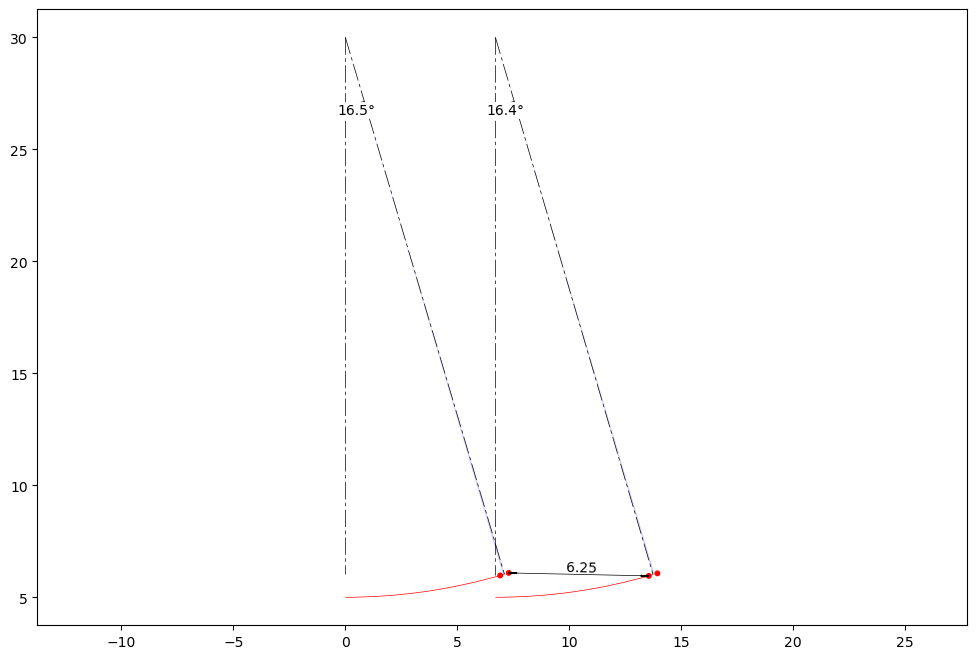

In [5]:
ax = plt.figure()
ax.figure.set_size_inches(12, 8)
ptsF1 = plot_balanco(plt, pF1, l=lcadeia+flecha, ang=ang1max, angmin=ang1min, angmax=ang1max, nc=ncond, angsc=0, esp=esp, angle_offset=3)
ptsF2 = plot_balanco(plt, pF2, l=lcadeia+flecha, ang=ang1min, angmin=ang1min, angmax=ang1max, nc=ncond, angsc=0, esp=esp, angle_offset=3)
p1,p2,_ = minDistancePts(ptsF1, ptsF2)
plot_dimension(plt, p1, p2, offset=0)
plt.axis('equal')
plt.show()

In [ ]:
# Low swing
Vr = 16.1
ang2 = anguloBalancoTB348(Vr, dcond, ncond, pcond, pcadeia, acadeia, Lm, Lp, gl=0.8)
ang2min, ang2max = nbr5422.anguloBalancoAssincrono(Vr, ang2)
ang2 = degrees(ang2)
ang2min = degrees(ang2min)
ang2max = degrees(ang2max)
print(f"Ângulo de balanço médio {ang2:.1f}°, mínimo {ang2min:.1f}º, máximo {ang2max:.1f}º.")

Ângulo de balanço médio 5.6°, mínimo 2.5º, máximo 8.6º.


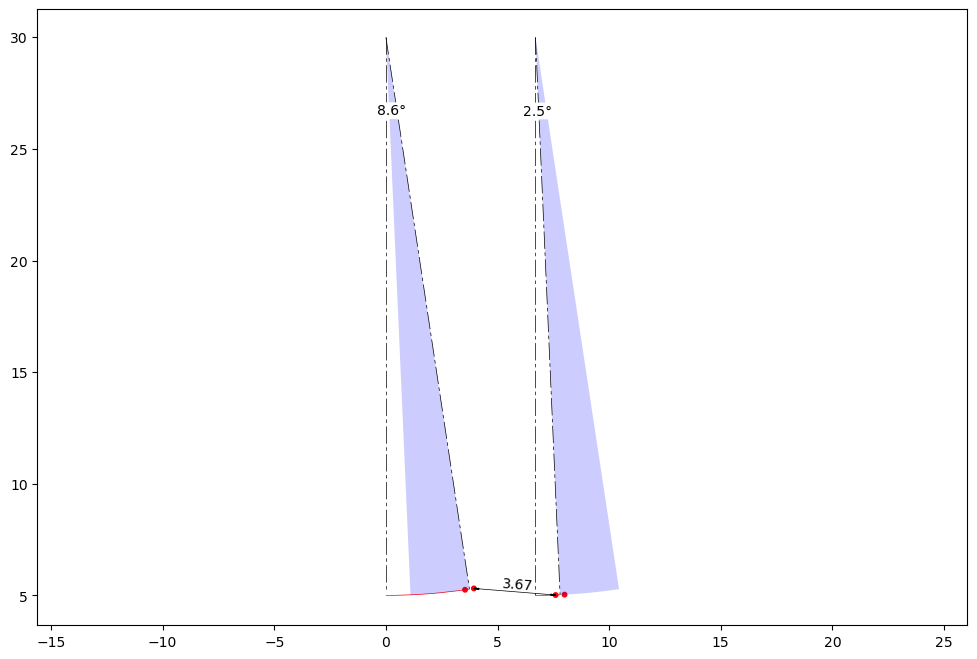

In [6]:
ax = plt.figure()
ax.figure.set_size_inches(12, 8)
ptsF1 = plot_balanco(plt, pF1, l=lcadeia+flecha, ang=ang2max, angmin=ang2min, angmax=ang2max, nc=ncond, angsc=0, esp=esp, angle_offset=3)
ptsF2 = plot_balanco(plt, pF2, l=lcadeia+flecha, ang=ang2min, angmin=ang2min, angmax=ang2max, nc=ncond, angsc=0, esp=esp, angle_offset=3)
p1,p2,_ = minDistancePts(ptsF1, ptsF2)
plot_dimension(plt, p1, p2, offset=0)
plt.axis('equal')
plt.show()